# <center> Social network Graph Link Prediction - Facebook Challenge

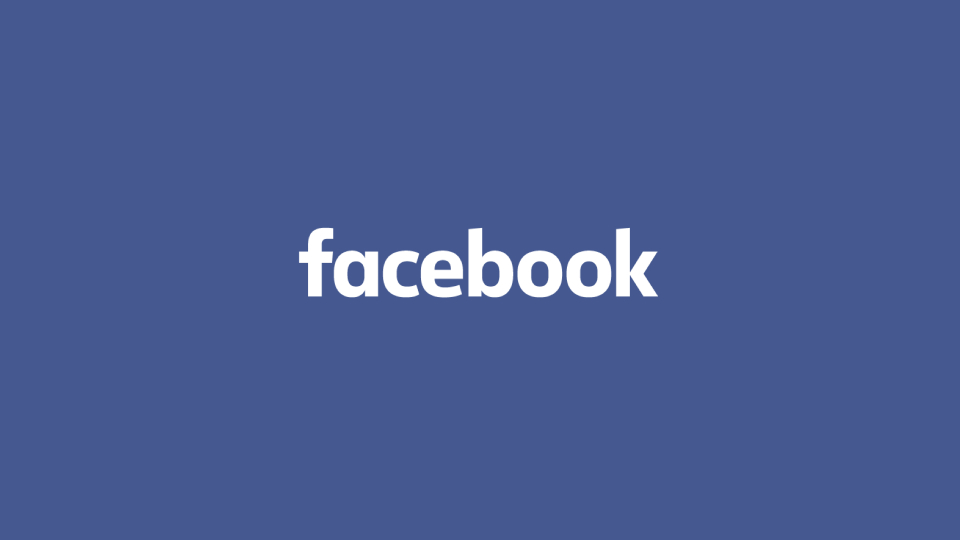

In [1]:
# Facebook Image
from IPython.display import Image
Image(filename='facebook.jpeg',width=900)

## Table of Contents

1. Introduction
2. Objective
3. Data Description
4. Exploratory Data Analysis
5. Feature Engineering
6. Construction of final dataset
7. Machine learning model
8. Insights & Conclusion

### 1. Introduction


- This dataset is provided by Facebook as a part of recruiting challenge on Kaggle. 
- This is a graph link prediction problem. The challenge is to predict missing links in a social nwtwork.

- Facebook has not provided the source of the data, we are just given directed social graphs from which some
edges have been deleted. Our task is to make predictions for users who might want to follow other users.

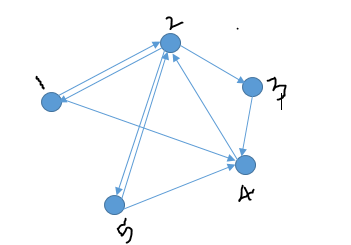

In [2]:
# Links Image
from IPython.display import Image
Image(filename='Link prediction.PNG',width=300)

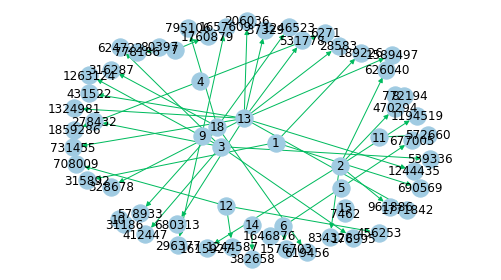

In [3]:
# Actual links between users 
# Extracting this image on GCP version of python had some issues, hence i have saved the image obtained 
# using python 3.6 on local machine on GCP.
# Code is as follows
# if not os.path.isfile('train_woheader_sample.csv'):
#    pd.read_csv('C:/Users/AVINASH/Desktop/AAIC/Portfolio/FB/train.csv', nrows=50).to_csv
# ('train_woheader_sample.csv',header=False,index=False)
    
# subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

# pos=nx.spring_layout(subgraph)
# The graph can be drawn using nx.draw()
# nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
# Saving the graph in pdf format.
# plt.savefig("graph_sample.pdf")
# print(nx.info(subgraph))

# This graph has 66 nodes & 50 edges. 
# Avg in_degree is 0.7576 & out_degree is 0.7576
# Actual links image.
from IPython.display import Image
Image(filename='Actual links.PNG',width=600)

### 2. Objective

__ Few Key observations from the graph __
- Consider the Link prediction image from cell number 2. This image is a social link directed graph.
- From the graph assume each circle to be a social media user. So we have 5 users. 
- Each circle is called a node or a vertex. And the line that connects one user to another is called an edge. 
- From the graph we get to know that U1 is following U2,U4 and is followed back by U2,it is denoted by blue edges. 
Similarly U5 is following U2,U4 and is followed back by U2.
- We also know from the graph U1 & U5 are yet to follow each other. And they have U2 as common friend/follower/user between them.

__ Considering the above graph our objective is to predict whether u1 would follow u5 or (vice-versa)? __

- Here the missing link is left blank.

__I have made few key observations based on my objectives:__

- 1) No low latency requirement : Given a pair of u_i & u_j we need not provide the class label within very short span of time (like few seconds or minutes). We can take reasonable time to provide an output. 

- 2) Predicting the probability value of a link is useful so as to recommend the highest probability links to the user.

### 3. Data Description

#### 3.1 Data Overview

Source of the data: https://www.kaggle.com/c/FacebookRecruiting

Train data contains 2 columns: 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  
    

##### This is how our train data looks like
Source_node Destination_node
- 1	        690569
- 1	        315892
- 1	        189226
- 2	        834328
- 2	        1615927
- 2	        1194519
- 2	        470294
- 2	        961886
- 2	        626040
- 3	        176995

- From the data we can say that user1 is a source node, following user690569 which is our destination node.
- We have 1862220 nodes & 9437519 directed edges in our dataset

#### 3.2 Mapping the problem as a supervised classification task

- We will map this problem to a binary classification task with 0 implying an absence of an edge & 1 implying the presence of an edge. Also we would featurize a pair of vertices (u_i,u_j) such that they help in predicting the absence or presence of an edge.


- Some reference links used for this task are:   
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

#### 3.3 Performance metric(s)

The task is a binary classification, so we can have the following performance metric(s).

So our performance metric(s) are: 
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

Reference link: https://www.kaggle.com/c/FacebookRecruiting#evaluation

In [4]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
%matplotlib inline
import matplotlib
from matplotlib.pylab import *
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
# This library (networkx) is specific to this case study.
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [5]:
# Here we are creating a csv file called train_woheader.csv 
# This code reads data from train.csv and creates a new csv file without any header.
if not os.path.isfile('train_woheader.csv'):
    traincsv = pd.read_csv('train.csv')
    # Checking if there is NA values.
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    # Returns the sum of duplicate rows.
    print("Number of duplicate entries: ",sum(traincsv.duplicated()))
    # Writing the traincsv file to train_woheader.csv
    traincsv.to_csv('train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    # Using the read_edgelist we are just reading the edges, also we are reading only the directed graphs using
    # DiGraph function, & the node takes integer values. 
    g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# nx.info prints out the info of 'g'.    
print(nx.info(g))

# There are 1862220 number of nodes & 9437519 edges.
# Assume u1 is followed by u2 & u3. Here in_degree of u1 is 2. So in_degree is the number of edges coming into a vertex.
# Similarly assume u1 follows u4,u7,u88. Here out_degree is 3. So out_degree is the number of edges going out from a vertex.
# On an average there are 5 edges coming into a vertex & similarly 5 edges going out from a vertex.

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


### 4. Exploratory Data Analysis

In [6]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


#### EDA - Number of followers for each person

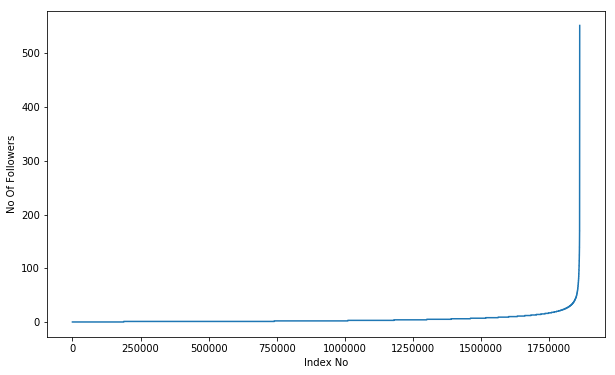

In [7]:
# No of followers for each person
%matplotlib inline
# No of followers for each person is obtained using in_degree().values()
indegree_dist = list(dict(g.in_degree()).values())
# We are sorting the data in ascending order.
indegree_dist.sort()
# We are plotting the sorted data.
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

# Very few person have huge number of followers Eg: One user has more than 500 followers. 
# Majority of them have very few followers.
# Only few users have 40+ followers.

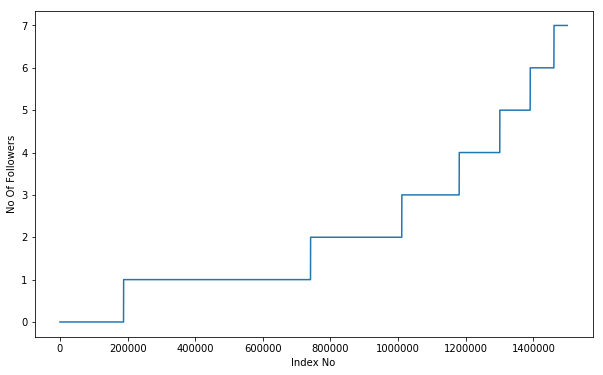

In [8]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

# When we zoom in the plot to 1.5 million users, we have:
# zero followers for almost 200k users.
# Just one follower for 550k users.
# Almost 1.4 million users have less than or equal to 7 followers.

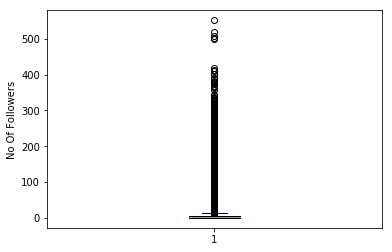

In [9]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

# Interpreting the box-plot is extremely difficult. We have a bunch of outliers suggesting only few users have
# very high following.

In [10]:
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

# 90% of my users have less than or equal to 12 followers. 
# 99 % of them have less than or equal to 40 followers. 
# One lucky user has 552 followers.

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


In [11]:
# Zooming into 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

# 99.9 percent of the users have less than or equal to 112 followers. 
# Only 0.1 percent of users have more than 112 followers.

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


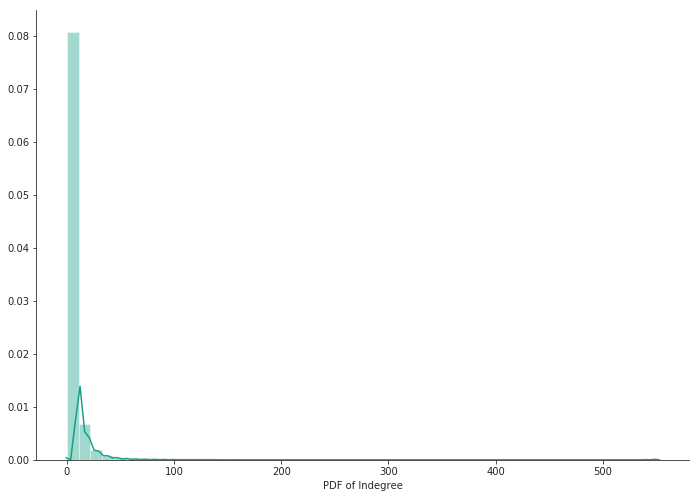

In [12]:
# Plotting the pdf of indegree - We have a very long tail & the plot is heavily skewed which 
# suggests that very few users have large following.
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

#### EDA - No of people each person is following

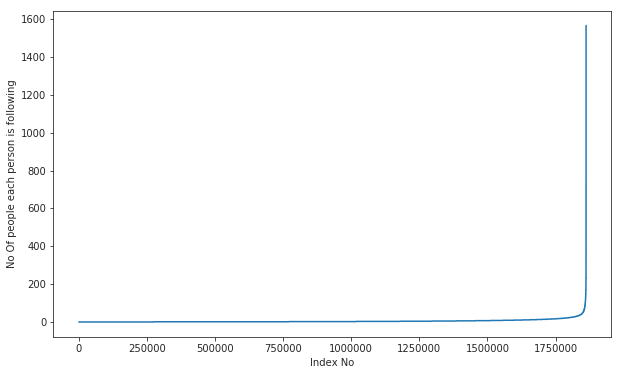

In [13]:
# No of people each person is following
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

# Looking at the graph we can say that majority of the users dont follow other users in large numbers.
# There is one user who follows more than 1500 users.

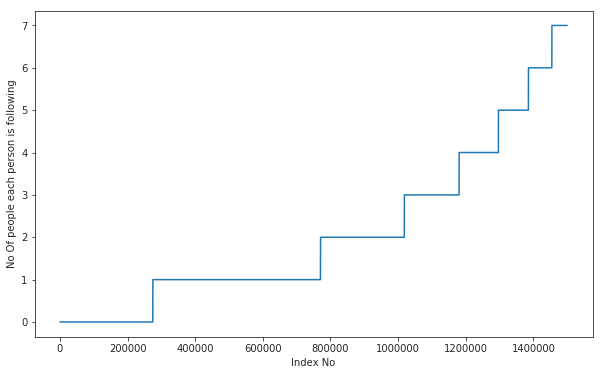

In [14]:
# We zoom in the outdegree_dist
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

# When we zoom in the plot to 1.5 million users, we have:
# Almost 250k users following none.
# Roughly 550k users just following one user.
# Almost 1.4 million users follow 7 or less users. 

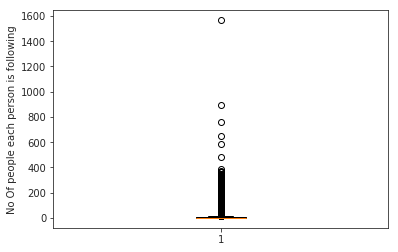

In [15]:
plt.boxplot(outdegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

# Most of the users follow very few users.
# One user follows almost 1600 users.

In [16]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

# The percentile values looks similar to what we observed in indegree_dist
# We have 90% of the users following 12 or less users.


90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [17]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

# We have 99.9% of users who are following 123 or less users.
# We have one user who is following 1566 users.

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


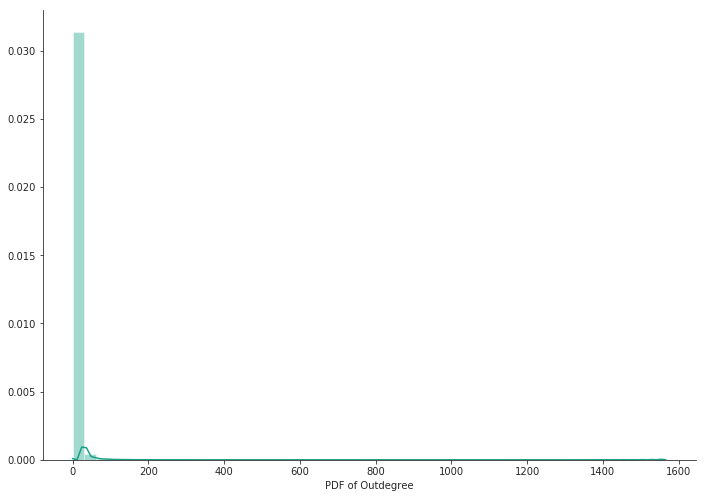

In [18]:
# Plotting the pdf of outdegree_dist
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

# The plot is heavily skewed suggesting there are very few users following a large number of users.
# Majority of the users follow 40 or less users.

In [19]:
# No of persons who are not following anyone
print('No of persons who are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

No of persons who are not following anyone are 274512 and % is 14.741115442858524


In [20]:
#No of persons having zero followers are
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist))

No of persons having zero followers are 188043 and % is 10.097786512871734


In [21]:
# No of persons who are following none and also having no followers at all
count=0
for i in g.nodes():
    # A predecessor of node n is a node m such that there exists a directed edge from m to n.
    if len(list(g.predecessors(i)))==0 :
        # A successor of node n is a node m such that there exists a directed edge from n to m.
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons who are following none and also having no followers at all are',count)

No of persons who are following none and also having no followers at all are 0


#### EDA - Both followers + following

In [22]:
# Both followers & following
from collections import Counter
# dict_in returns a dictonary of number of users following u_i 
# Eg if we print dict_in we get {1:3,2:4,3:11}
dict_in = dict(g.in_degree())
# dict_out will return us number of users followed by u_i
# Eg if we print dict_out we get {1:3,2:6,3:6}
dict_out = dict(g.out_degree())
# d will return us sum of indegree & outdegree {1:6,2:10,3:17}
d = Counter(dict_in) + Counter(dict_out)
# We are just storing d in list format. [6,10,17...]
in_out_degree = np.array(list(d.values()))

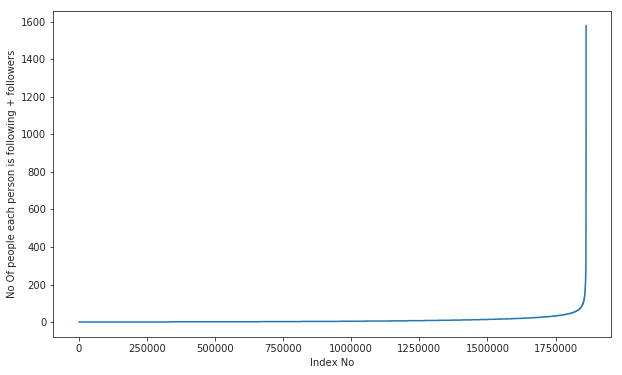

In [23]:
# Plotting of in_out_degree
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

# Looking at the graph we can say that majority of the users dont follow other users and have a very few followers.

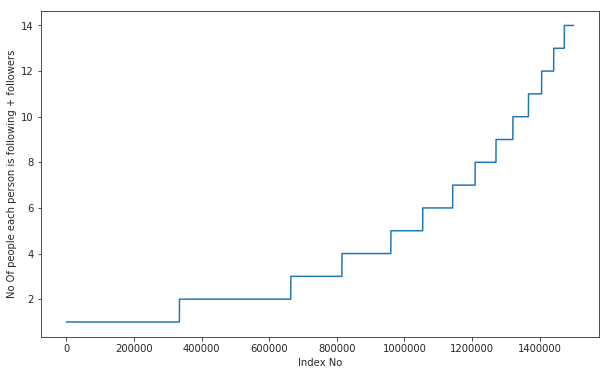

In [24]:
# Zooming in the in_out_degree 
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

# Around 1.5 million users have both followers + following count less than or equal to 14.

In [25]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

# 90 percent of the users have both followers + following count less than or equal to 24.
# There is one user who has both followers + following count of 1579

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [26]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

# 99.1 percent of the users have both followers + following count less than or equal to 83.

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


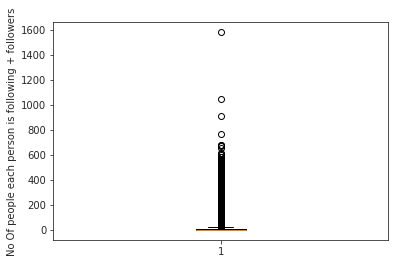

In [27]:
# Box plot of both following + followers.
plt.boxplot(in_out_degree)
plt.ylabel('No Of people each person is following + followers')
plt.show()

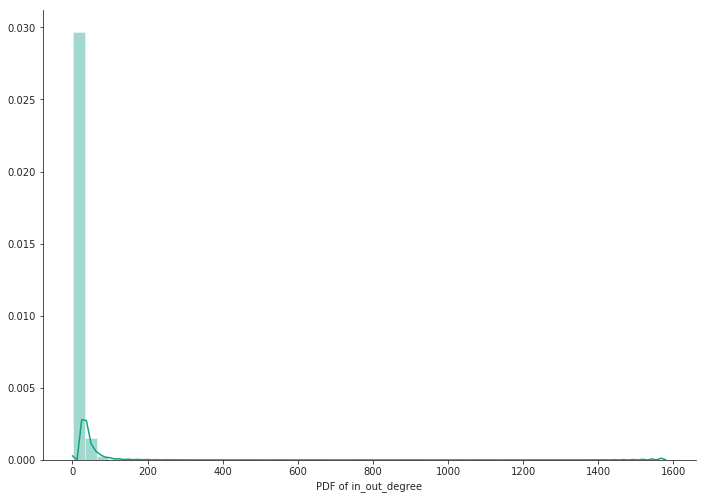

In [28]:
# Plotting the pdf of in_out_degree 
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(in_out_degree, color='#16A085')
plt.xlabel('PDF of in_out_degree')
sns.despine()

# The plot is heavily skewed suggesting there are very few users with both following + followers.

In [29]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [30]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [31]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


#### EDA - Posing a problem as classification problem

__Generating some edges which are not present in graph for supervised learning__

- If we closely look at our train data we have been given 2 columns, Source node & Destination node and for all datapoints there is an edge present, which means yi's for all datapoints is 1. So we do not have data for class label 0. If we want to pose this problem as binary classification task we need data for both class labels 0 & 1.So we now create datapoints for which there would be no edges so that they can be labelled as 0.Total possible number of edges that could be created is (nodes)*(nodes-1). This is a very large value. But at present we have only 9.43 million edges which is a small value compared to total edges that could be created. 

__How to create datapoints for class label 0?__
* From the total possible edges that could be created, we randomly sample pairs of vertices for which there could be an edge present, but right now its not present.

__How many such datapoints would be created?__
* The number of the datapoints created for class label 0 would be same as the number of datapoints present for class label 1
so that the dataset is balanced.




In [32]:
%%time
# Generating missing links for class label 0.
import random
if not os.path.isfile('missing_edges_final.p'):
    # Getting all set of edges
    r = csv.reader(open('train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    # The number of datapoints generated for class label 0 is same as the datapoints we have for class label 1.
    while (len(missing_edges)<9437519):
        # We randomly sample pairs of vertices.
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        # Here we check if there is an edge between two vertices.
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                # We also set a condition that if the path between two vertices is greater than 2,
                # and it has no edge between them add that point to the dataset.
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('missing_edges_final.p','rb'))

CPU times: user 2 s, sys: 1.53 s, total: 3.53 s
Wall time: 4.07 s


In [33]:
len(missing_edges)

9437519

#### EDA - Training and Test data split:

In [34]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('train_pos_after_eda.csv')) and (not os.path.isfile('test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    # Train test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones
                                                                         (len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros
                                                                         (len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    # Removing header and saving
    X_train_pos.to_csv('train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from traning data only 
    del missing_edges

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [35]:
if (os.path.isfile('train_pos_after_eda.csv')) and (os.path.isfile('test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # Finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


In [36]:
# Final train and test data sets
if (not os.path.isfile('train_after_eda.csv')) and \
(not os.path.isfile('test_after_eda.csv')) and \
(not os.path.isfile('train_y.csv')) and \
(not os.path.isfile('test_y.csv')) and \
(os.path.isfile('train_pos_after_eda.csv')) and \
(os.path.isfile('test_pos_after_eda.csv')) and \
(os.path.isfile('train_neg_after_eda.csv')) and \
(os.path.isfile('test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('train_after_eda.csv',header=False,index=False)
    X_test.to_csv('test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [37]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of target variable in train",y_train.shape)
print("Shape of target variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of target variable in train (15100030,)
Shape of target variable in test (3775008,)


In [38]:
if os.path.isfile('train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("Please download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


### 5. Feature Engineering

#### 5.1 Jaccard Index

http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [39]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [40]:
# one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [41]:
# node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [42]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [43]:
print(jaccard_for_followers(273084,470294))

0.0


In [44]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


#### 5.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [46]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [47]:
print(cosine_for_followees(273084,1505602))

0.0


In [48]:
print(cosine_for_followees(273084,1635354))

0


In [49]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [50]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [51]:
print(cosine_for_followers(669354,1635354))

0


#### Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

#### 5.3 Page Ranking

https://en.wikipedia.org/wiki/PageRank

In [52]:
if not os.path.isfile('page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('page_rank.p','wb'))
else:
    pr = pickle.load(open('page_rank.p','rb'))

In [53]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
# Average
count = 0
_sum = 0
for key in pr:
    count += 1
    _sum += pr[key]

print('mean ', _sum/count)

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean  5.615699699365892e-07


In [54]:
#for imputing to nodes which are not there in Train data
count = 0
_sum = 0
for key in pr:
    count += 1
    _sum += pr[key]

print('mean ', _sum/count)

mean  5.615699699365892e-07


#### Other Graph Features

__5.4 Shortest Path__

Getting Shortest path between two nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path.

In [55]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [56]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [57]:
#testing
compute_shortest_path_length(669354,1635354)

-1

#### 5.5 Checking for same community

In [58]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [59]:
belongs_to_same_wcc(861, 1659750)

0

In [60]:
belongs_to_same_wcc(669354,1635354)

0

#### 5.5 Adamic/Adar Index:

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [61]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [62]:
calc_adar_in(1,189226)

0

In [63]:
calc_adar_in(669354,1635354)

0

#### 5.6 Is person was following back:

In [64]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [65]:
follows_back(1,189226)

1

In [66]:
follows_back(669354,1635354)

0

#### 5.7 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [67]:
if not os.path.isfile('katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('katz.p','wb'))
else:
    katz = pickle.load(open('katz.p','rb'))

In [68]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])

# Average
count = 0
_sum = 0
for key in katz:
    count += 1
    _sum += katz[key]

print('mean ', _sum/count)

min 0.0007313532484065916
max 0.003394554981699122
mean  0.0007483800935504637


#### 5.8 Hits Score

The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [69]:
if not os.path.isfile('hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('hits.p','wb'))
else:
    hits = pickle.load(open('hits.p','rb'))

In [70]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])

min 0.0
max 0.004868653378780953


### 6. Construction of final dataset

#### 6.1 Reading a sample of Data from both train and test

In [71]:
import random
if os.path.isfile('train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the length of the file name
    # here we have hardcoded the number of lines as 15100028
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [72]:
if os.path.isfile('test_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the length of the file name
    # here we have hardcoded the number of lines as 3775006
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [73]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to eliminate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to eliminate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to eliminate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to eliminate in test data are 3725006


In [74]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1114859,813966,1


In [75]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1356689,408566,1


#### 6.2 Adding a set of features:

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [76]:
if not os.path.isfile('storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [77]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [78]:
if not os.path.isfile('storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_s'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_s'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage1.h5', 'test_df',mode='r')

#### 6.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [79]:
if not os.path.isfile('storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: 
                                                        calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: 
                                                      calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: 
                                                follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: 
                                                follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: 
                                                belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: 
                                                belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: 
                                compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: 
                                compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage2.h5', 'test_df',mode='r')

#### 6.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently.

In [80]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:18<00:00, 97254.28it/s]


In [81]:
if not os.path.isfile('storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage3.h5', 'test_df',mode='r')

#### 6.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [82]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [83]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [84]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [85]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [86]:
if not os.path.isfile('storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

### 7. Machine learning model

In [87]:
# Final data to be trained
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [88]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [89]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [90]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9063252121775113 test Score 0.8745605278006858
Estimators =  50 Train Score 0.9205725512208812 test Score 0.9125653355634538
Estimators =  100 Train Score 0.9238690848446947 test Score 0.9141199714153599
Estimators =  250 Train Score 0.9239789348046863 test Score 0.9188007232664732
Estimators =  450 Train Score 0.9237190618658074 test Score 0.9161507685828595


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

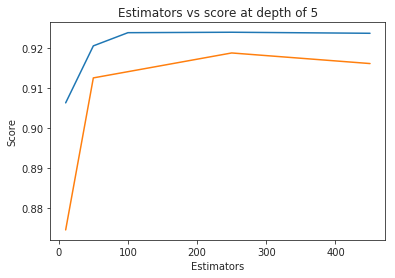

In [91]:
# Doing a random search to obtain best hyper parameters
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8916120853581238 test Score 0.8687934859875491
depth =  9 Train Score 0.9572226298198419 test Score 0.9222953031452904
depth =  11 Train Score 0.9623451340902863 test Score 0.9252318758281279
depth =  15 Train Score 0.9634267621927706 test Score 0.9231288356496615
depth =  20 Train Score 0.9631629153051491 test Score 0.9235051024711141
depth =  35 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  50 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  70 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  130 Train Score 0.9634333127085721 test Score 0.9235601652753184


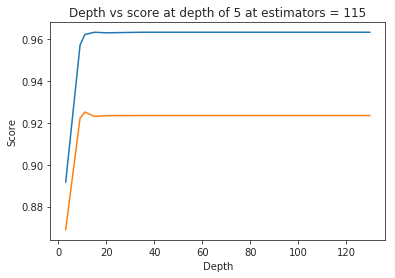

In [92]:
# Obtaining best hyper parameters
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [93]:
# After obtaining best parameters - building a model
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96225043 0.96215493 0.96057081 0.96194015 0.96330005]
mean train scores [0.96294922 0.96266735 0.96115674 0.96263457 0.96430539]


In [94]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [95]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [96]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [97]:
# Obtaining F1 scores
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9652533106548414
Test f1 score 0.9241678239279553


In [98]:
# Creating a simple function to plot confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


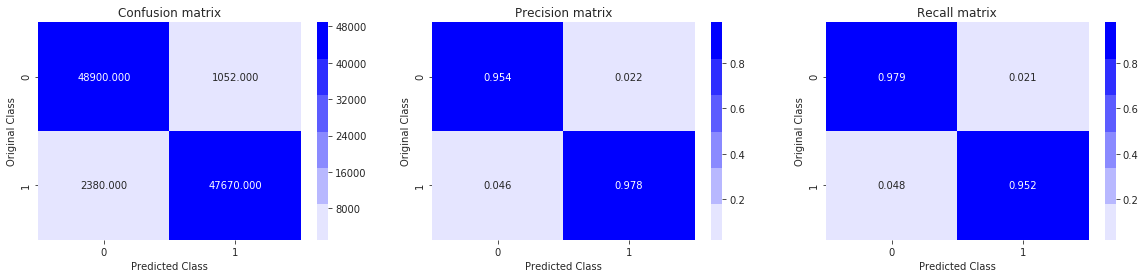

Test confusion_matrix


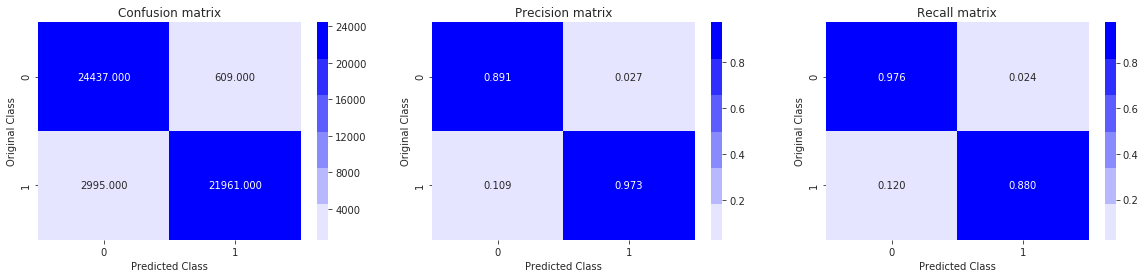

In [99]:
# PLotting a confusion matrix
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

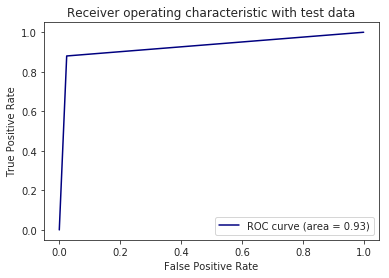

In [100]:
# ROC curve
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

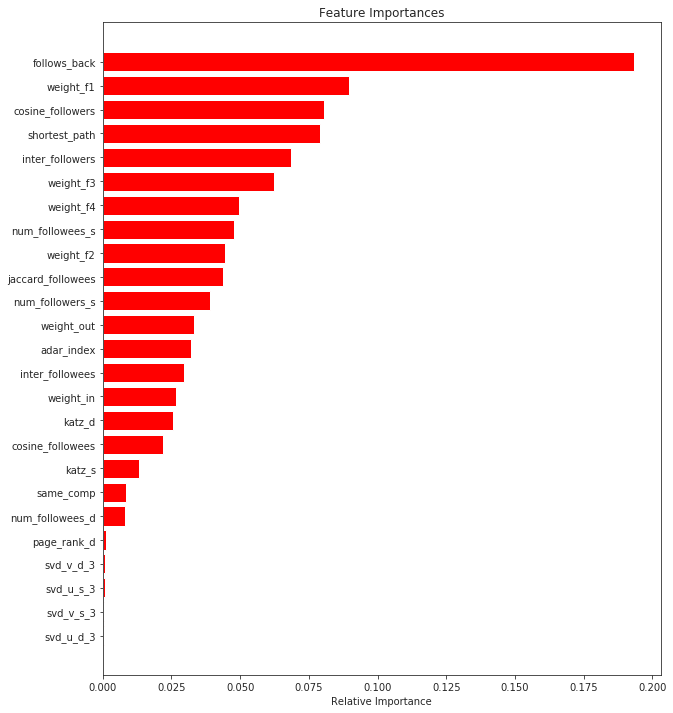

In [101]:
# Getting feature importance
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 8. Insights & Conclusion

In this case study more importance is given to feature engineering than model building, because the dataset was built using these features. 

However in line with our objective of predicting missing links we have built a Random Forest classifier and the model on test data achieves 93% accuracy. 

When we observe our feature importance graph, follows_back,weight_f1 turn out to be most important features. 

__follows_back__ : Given two vertices 'a' & 'b', we want to know if 'b' follows 'a'. in our data 'a' would follow 'b' and 'a' would follow 'c'. Now given this we want to know if 'b' is following back 'a'. The outcome of this feature is binary. 

Similarly, __weight_f1__ is a addition of weight_in + weight_out feature. Let's take an example of feature weight_in. Assume we have two users u_i & u_j, and assume u_i is a celebrity and u_j is a non-celeb. Here u_i would have millions of followers, and in u_i probability of 2 random followers knowing each other would be very less. Consider u_j who is a non-celeb. In u_j who has just few followers, probability that 2 followers of u_j would know each other is very high. Now the weight_in feature would give high value for those vertices where the chance of knowing each other is high provided that u_j is a non-celeb and also provided that there is no connection between those 2 followers as of now. 

__Conclusion__ : There could be room for further feature engineering, however our model with current set of features has achieved good accuracy. This model could be sent for management for review.